In [1]:
import inspect
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os 
import seaborn as sns
import warnings

%load_ext autoreload
%autoreload 2

In [2]:
dati = pd.read_pickle("dati.pkl")
y=pd.read_pickle("y.pkl")

In [3]:
dati.head()

,pixel_0_0,pixel_0_1,pixel_0_2,pixel_0_3,pixel_0_4,pixel_0_5,pixel_0_6,pixel_0_7,pixel_0_8,pixel_0_9,...,pixel_31_22,pixel_31_23,pixel_31_24,pixel_31_25,pixel_31_26,pixel_31_27,pixel_31_28,pixel_31_29,pixel_31_30,pixel_31_31
0,0,0,0,0,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,1,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0


In [34]:
Xsub = dati[0:10000]
ysub = y[0:10000]

In [35]:
from funzioni import indice_gini
from funzioni import tasso_errata_classificazione

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz

In [38]:
X_train, X_val, y_train, y_val = train_test_split(Xsub, ysub, test_size=0.25, random_state=42)

In [39]:
dtc = Pipeline([ 
    ("tree", DecisionTreeClassifier())
])

dtc.fit(X_train, y_train)

y_pred = dtc.predict(X_val)
dtc_acc = accuracy_score(y_val, y_pred)

#print('Accuratezza DummyClassifier("most_frequent"): {:.1f}%'.format(100 * dc_acc))
print("Accuratezza DecisionTreeClassifier(): {:.2f}%".format(100 * dtc_acc))

Accuratezza DecisionTreeClassifier(): 30.00%


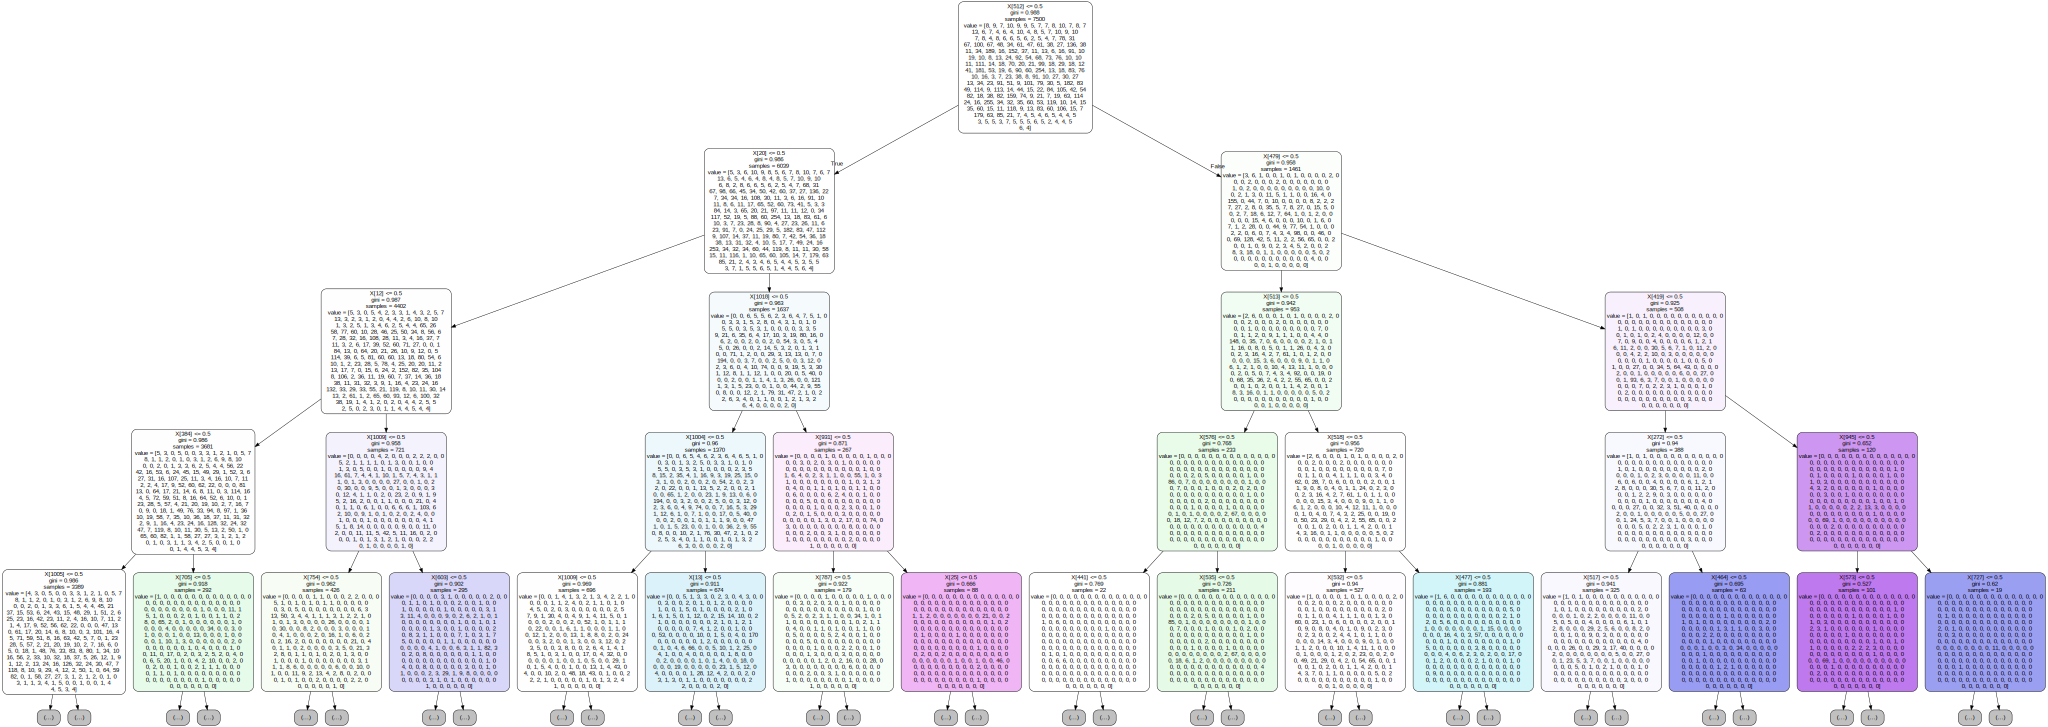

In [50]:
dot_data = export_graphviz(
    decision_tree=dtc.named_steps["tree"], 
    max_depth=4,
    filled=True,
    rounded=True,
    node_ids=None
)
display(graphviz.Source(dot_data))